# Import the required packages and data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import date
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
import warnings
warnings.simplefilter("ignore")


from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import utils
# for modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

2021-09-27 23:03:43.949924: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-27 23:03:43.949972: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
fraudTest = pd.read_csv("fraudTest.csv", index_col="Unnamed: 0")
fraudTest.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


# Data Inspection

In [3]:
fraudTest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 555719 entries, 0 to 555718
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  555719 non-null  object 
 1   cc_num                 555719 non-null  int64  
 2   merchant               555719 non-null  object 
 3   category               555719 non-null  object 
 4   amt                    555719 non-null  float64
 5   first                  555719 non-null  object 
 6   last                   555719 non-null  object 
 7   gender                 555719 non-null  object 
 8   street                 555719 non-null  object 
 9   city                   555719 non-null  object 
 10  state                  555719 non-null  object 
 11  zip                    555719 non-null  int64  
 12  lat                    555719 non-null  float64
 13  long                   555719 non-null  float64
 14  city_pop               555719 non-nu

In [4]:
# inspect all non numeric columns by counting unique values 
for column in fraudTest.select_dtypes(include = "object").columns:
    print(f"{column}: {fraudTest[column].nunique()}")

trans_date_trans_time: 544760
merchant: 693
category: 14
first: 341
last: 471
gender: 2
street: 924
city: 849
state: 50
job: 478
dob: 910
trans_num: 555719


In [5]:
# drop all columns not required for modelling 
fraudTest.drop(["trans_date_trans_time", "first", "last", "cc_num"], axis = 1, inplace = True)
fraudTest.columns

Index(['merchant', 'category', 'amt', 'gender', 'street', 'city', 'state',
       'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num',
       'unix_time', 'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [6]:
# check existence of null rows
fraudTest.isna().sum()

merchant      0
category      0
amt           0
gender        0
street        0
city          0
state         0
zip           0
lat           0
long          0
city_pop      0
job           0
dob           0
trans_num     0
unix_time     0
merch_lat     0
merch_long    0
is_fraud      0
dtype: int64

In [7]:
# check existence of duplicate rows
fraudTest.duplicated().sum()

0

In [8]:
# transform date of birth to age
fraudTest["dob"] = pd.to_datetime(fraudTest["dob"])

 
def calculateAge(dob):
    today = date.today()
    age = today.year - dob.year - \
    ((today.month, today.day) < (dob.month, dob.day))
 
    return age

age = [] #set age as an empty string 

for i in fraudTest["dob"]:
    onesAge = calculateAge(i)
    age.append(onesAge)
    
# drop the dob variables
fraudTest.drop("dob", axis = 1, inplace = True)

# add the age column to the dataframe
fraudTest["age"] = age

# Explanatory Data Analysis

## Distribution


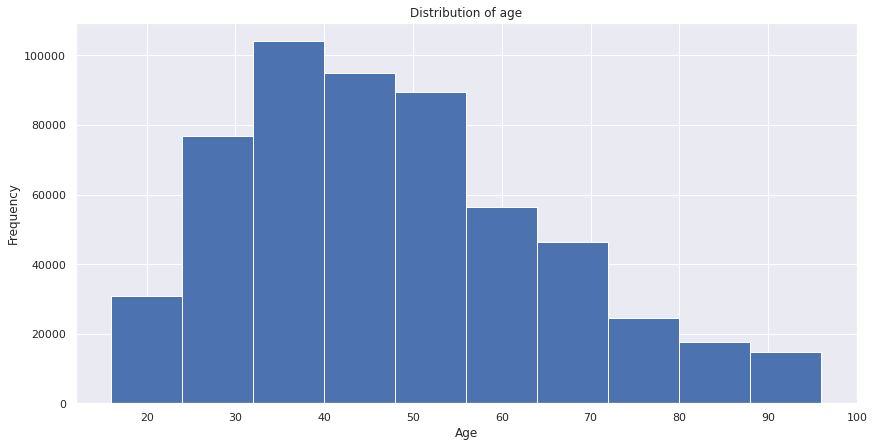

In [9]:
# distribution of age 
%matplotlib inline
sns.set()

plt.figure(figsize = (14, 7))
plt.title("Distribution of age")
plt.hist(fraudTest["age"])
plt.ylabel("Frequency")
plt.xlabel("Age")
plt.show()

## Composition

0    553574
1      2145
Name: is_fraud, dtype: int64


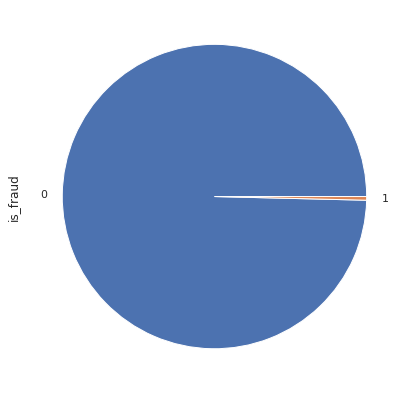

In [10]:
plt.figure(figsize = (14, 7))
fraudTest["is_fraud"].value_counts().plot(kind = "pie")
print(fraudTest["is_fraud"].value_counts())

## Relationship

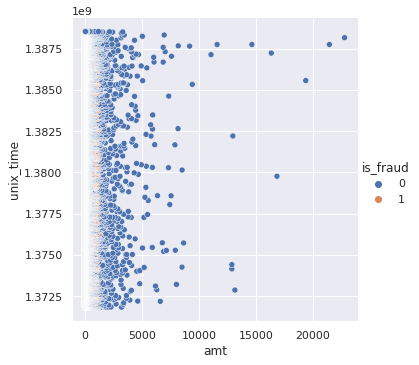

In [11]:
# plot a relational plot to get the relation between different variables 
sns.relplot(y = 'unix_time', x = 'amt' , hue = 'is_fraud',data = fraudTest)

## Comparison 

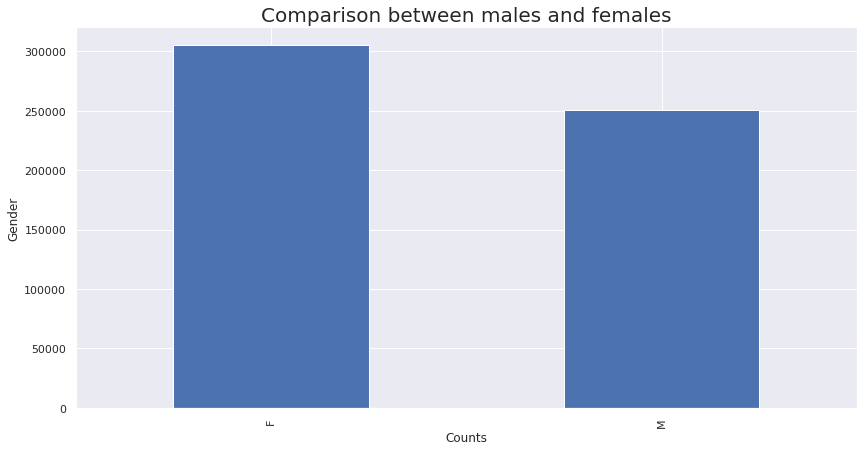

In [12]:
%matplotlib inline
sns.set()

plt.figure(figsize = (14, 7))
plt.title('Comparison between males and females', fontsize = 20)
fraudTest["gender"].value_counts().plot(kind = "bar")
plt.xlabel("Counts")
plt.ylabel("Gender")
plt.show()

## Coorelation

Text(0.5, 1.0, 'Correlation between variables')

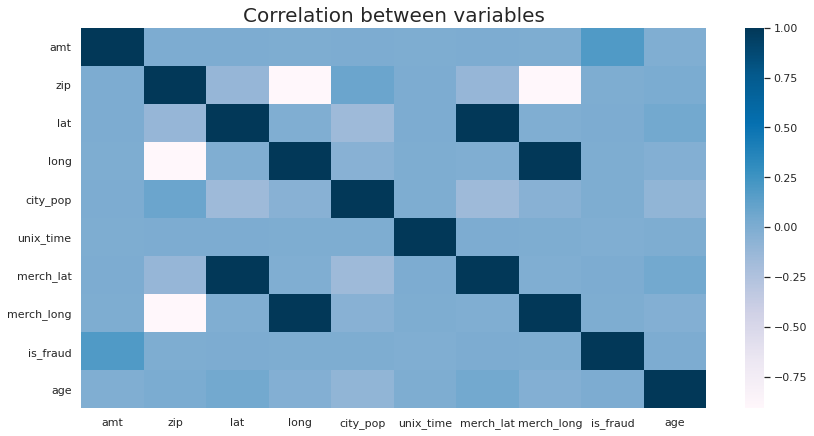

In [13]:
%matplotlib inline
sns.set()

plt.figure(figsize = (14, 7))
ax = sns.heatmap(fraudTest.corr(), cmap = "PuBu")
ax.set_title("Correlation between variables", fontsize = 20)


# Data Transformation

## Label Encoding 

In [14]:
non_numeric_var = fraudTest.select_dtypes(include = "object").columns
non_numeric_var

Index(['merchant', 'category', 'gender', 'street', 'city', 'state', 'job',
       'trans_num'],
      dtype='object')

In [15]:
le = LabelEncoder()


for var in non_numeric_var:
    new_var = var + "_le" #rename the variables 
    fraudTest[new_var] = le.fit_transform(fraudTest[var]) 
    fraudTest.drop(var, axis = 1, inplace = True) #drop the non_numeric columns

**Split into indipendent and target variables**

In [16]:
# take a sample of the data to reduce training time

fraudTest = fraudTest.sample(n = 200000)

In [17]:
X = fraudTest.drop("is_fraud", axis = 1)
y = fraudTest["is_fraud"]

## Imbalanced Learning
Since the fraudulent transaction were very low compared to non-fraudulent ones, imbalanced Learning had to be done to reduce overfittting.
<br>
The pie chart above depicts so.
<br>
Random Oversampling will increase the instances of the minority to create balance 

### Random OverSampling 

In [18]:
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(X, y)

## Scaling the data (Min Max Scaler)

In [19]:
"""
MinMaxSacler scales the data to reduces the time taken for machine learning models to learn
"""

scaler = MinMaxScaler(feature_range=(0, 1))

scaled_X = scaler.fit_transform(X)


## Train Test Split 

In [20]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = 0.3)

# Model Training 

## Logistic Regression

In [21]:
LogReg = LogisticRegression(random_state = 42)

In [22]:
LogReg.fit(X_train, y_train)

LogisticRegression(random_state=42)

## Decision Tree Classifier

In [23]:
dt_clf = DecisionTreeClassifier(random_state = 42)

In [24]:
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

## Random Forest Classifier

In [25]:
rf_clf = RandomForestClassifier(random_state = 42)

In [26]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Naive Bayes 

In [29]:
naive_clf = GaussianNB()

In [30]:
naive_clf.fit(X_train, y_train)

GaussianNB()

## TensorFlow (Neural Networks)

### build a model

In [31]:
model = Sequential()
model.add(Dense(16, input_shape=(X.shape[1],), activation='relu')) # Add an input shape! (features,)
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary() 

2021-09-27 23:06:38.110354: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                288       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


2021-09-27 23:06:38.377160: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2021-09-27 23:06:38.398216: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (street-analyst): /proc/driver/nvidia/version does not exist


### compile the model

In [32]:
model.compile(optimizer='Adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = EarlyStopping(monitor='val_accuracy', 
                                   mode='max', # don't minimize the accuracy!
                                   patience=10,
                                   restore_best_weights=True)

In [33]:
TensorflowAmazonLex = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=10,
                    batch_size=10,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

2021-09-27 23:06:42.657206: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-27 23:06:42.723365: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2494430000 Hz


Epoch 1/10
22316/22316 [==============================] - 40s 2ms/step - loss: 0.4037 - accuracy: 0.8141 - val_loss: 0.3502 - val_accuracy: 0.8385
Epoch 2/10
22316/22316 [==============================] - 38s 2ms/step - loss: 0.3415 - accuracy: 0.8453 - val_loss: 0.3285 - val_accuracy: 0.8471
Epoch 3/10
22316/22316 [==============================] - 37s 2ms/step - loss: 0.3150 - accuracy: 0.8564 - val_loss: 0.3042 - val_accuracy: 0.8691
Epoch 4/10
22316/22316 [==============================] - 37s 2ms/step - loss: 0.2881 - accuracy: 0.8712 - val_loss: 0.2758 - val_accuracy: 0.8790
Epoch 5/10
22316/22316 [==============================] - 39s 2ms/step - loss: 0.2739 - accuracy: 0.8783 - val_loss: 0.2795 - val_accuracy: 0.8758
Epoch 6/10
22316/22316 [==============================] - 38s 2ms/step - loss: 0.2648 - accuracy: 0.8830 - val_loss: 0.2601 - val_accuracy: 0.8899
Epoch 7/10
22316/22316 [==============================] - 42s 2ms/step - loss: 0.2590 - accuracy: 0.8854 - val_loss: 0

# Evaluation of the models

## Predictions 

In [34]:
# Logistic Regression
LogRegY_pred = LogReg.predict(X_test)

In [35]:
# Decision Tree Classifier
dt_clfY_pred = dt_clf.predict(X_test)

In [36]:
#Random Forest Classifier
rf_clfY_pred = rf_clf.predict(X_test)

In [39]:
# Naive Bayes 
naive_clfY_pred = naive_clf.predict(X_test)

In [57]:
# TensorFlow (Neural Networks)
modelY_pred = model.predict(X_test)

# convert to binary from continous
TensorFlowY_pred = pd.cut(modelY_pred.flatten(), bins = 2, labels = False)

## Accuracy Score

In [59]:
model_names = ["TensorFlow"]

print(f"Logistic Regression: {accuracy_score(y_test, LogRegY_pred)}")
print(f"Decision Tree Classifier: {accuracy_score(y_test, dt_clfY_pred)}")
print(f"Random Forest Classifier: {accuracy_score(y_test, rf_clfY_pred)}")
print(f"Naive Bayes: {accuracy_score(y_test, naive_clfY_pred)}")
print(f"TensorFlow: {accuracy_score(y_test, TensorFlowY_pred)}")

Logistic Regression: 0.845487243831033
Decision Tree Classifier: 0.999155165202844
Random Forest Classifier: 0.9997657883730656
Naive Bayes: 0.8252864910079465
TensorFlow: 0.8956168966959431


## Confusion Matrix

<AxesSubplot:>

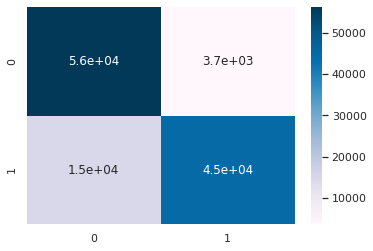

In [61]:
# Linear Regression
LogReg_cm = confusion_matrix(y_test,LogRegY_pred)
sns.heatmap(LogReg_cm,annot=True, cmap = "PuBu")

<AxesSubplot:>

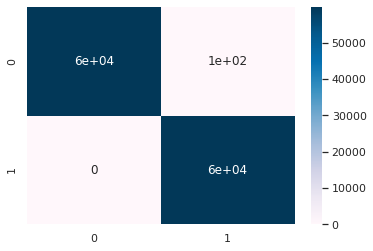

In [62]:
#Decision Tree Classifier

dt_clf_cm = confusion_matrix(y_test,dt_clfY_pred)
sns.heatmap(dt_clf_cm,annot=True, cmap = "PuBu")

<AxesSubplot:>

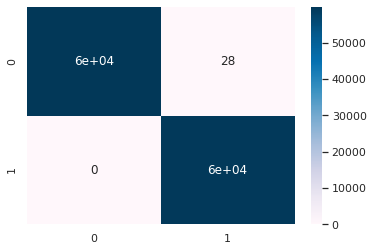

In [63]:
# Random Forest Classifier

rf_clf_cm = confusion_matrix(y_test,rf_clfY_pred)
sns.heatmap(rf_clf_cm,annot=True, cmap = "PuBu")

<AxesSubplot:>

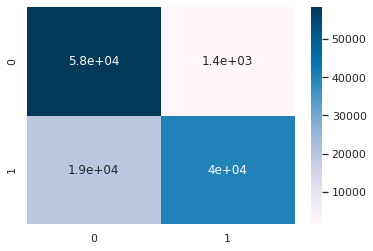

In [64]:
# Naive Bayes

naive_clf_cm = confusion_matrix(y_test,naive_clfY_pred)
sns.heatmap(naive_clf_cm,annot=True, cmap = "PuBu")

<AxesSubplot:>

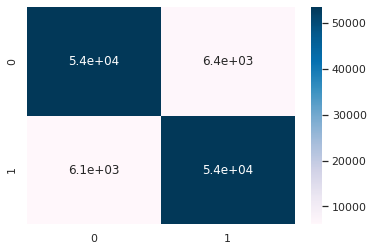

In [65]:
# TensorFlow

TensorFlow_cm = confusion_matrix(y_test,TensorFlowY_pred)
sns.heatmap(TensorFlow_cm,annot=True, cmap = "PuBu")

## ROC curve

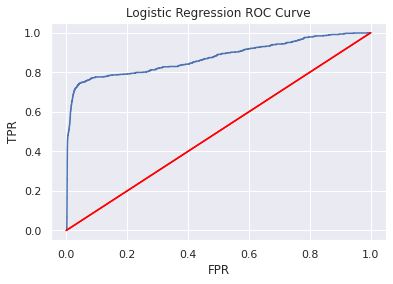

In [70]:
## Logistic Regression Model
prob = LogReg.predict_proba(X_test)[:,1]
fpr,tpr,threshold = roc_curve(y_test,prob)
#Plotting Roc Curve
plt.plot(fpr,tpr)
plt.plot([[0,0],[1,1]],color='red',linestyle = '-')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Logistic Regression ROC Curve')
plt.show()

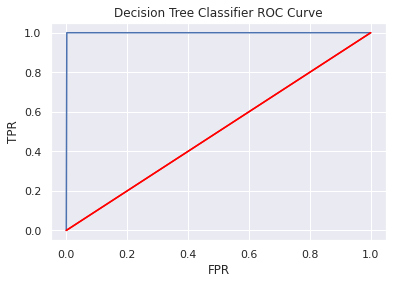

In [71]:
## Decision Tree Classifier Model
prob = dt_clf.predict_proba(X_test)[:,1]
fpr,tpr,threshold = roc_curve(y_test,prob)
#Plotting Roc Curve
plt.plot(fpr,tpr)
plt.plot([[0,0],[1,1]],color='red',linestyle = '-')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Decision Tree Classifier ROC Curve')
plt.show()

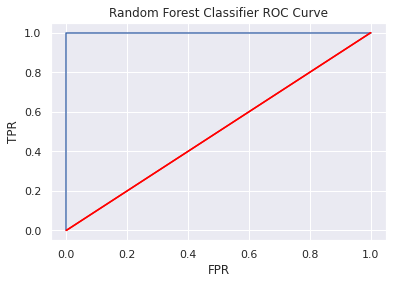

In [72]:
## Random Forest Classifier Model
prob = rf_clf.predict_proba(X_test)[:,1]
fpr,tpr,threshold = roc_curve(y_test,prob)
#Plotting Roc Curve
plt.plot(fpr,tpr)
plt.plot([[0,0],[1,1]],color='red',linestyle = '-')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Random Forest Classifier ROC Curve')
plt.show()

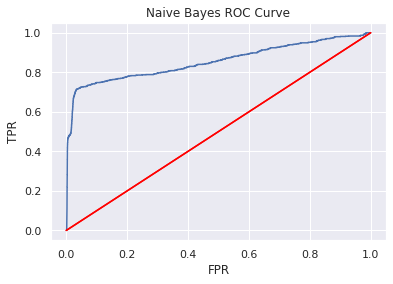

In [73]:
## Naive Bayes Model
prob = naive_clf.predict_proba(X_test)[:,1]
fpr,tpr,threshold = roc_curve(y_test,prob)
#Plotting Roc Curve
plt.plot(fpr,tpr)
plt.plot([[0,0],[1,1]],color='red',linestyle = '-')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Naive Bayes ROC Curve')
plt.show()

## Classification Report

In [77]:
# Logistic regression
LogRegReport = classification_report(y_test, LogRegY_pred)
print(LogRegReport)

              precision    recall  f1-score   support

           0       0.79      0.94      0.86     59913
           1       0.92      0.75      0.83     59637

    accuracy                           0.85    119550
   macro avg       0.86      0.85      0.84    119550
weighted avg       0.86      0.85      0.84    119550



In [78]:
# Decision Tree Classifier
dt_clfReport = classification_report(y_test, dt_clfY_pred)
print(dt_clfReport)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59913
           1       1.00      1.00      1.00     59637

    accuracy                           1.00    119550
   macro avg       1.00      1.00      1.00    119550
weighted avg       1.00      1.00      1.00    119550



In [79]:
# Random Forest Classifier
rf_clfReport = classification_report(y_test, rf_clfY_pred)
print(rf_clfReport)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59913
           1       1.00      1.00      1.00     59637

    accuracy                           1.00    119550
   macro avg       1.00      1.00      1.00    119550
weighted avg       1.00      1.00      1.00    119550



In [80]:
# Naive Bayes
naive_clfReport = classification_report(y_test, naive_clfY_pred)
print(naive_clfReport)

              precision    recall  f1-score   support

           0       0.75      0.98      0.85     59913
           1       0.97      0.67      0.79     59637

    accuracy                           0.83    119550
   macro avg       0.86      0.82      0.82    119550
weighted avg       0.86      0.83      0.82    119550



In [83]:
# TensorFlow Amazon Lex

TensorFlowReport = classification_report(y_test, TensorFlowY_pred)
print(TensorFlowReport)

              precision    recall  f1-score   support

           0       0.90      0.89      0.90     59913
           1       0.89      0.90      0.90     59637

    accuracy                           0.90    119550
   macro avg       0.90      0.90      0.90    119550
weighted avg       0.90      0.90      0.90    119550



# Conclusion

The finding from the visualizations were:

* Most of the people in the data were in middle age gap(35 to 45).
* Fraudulent Transactions were very few compared to non-fraudulent transactions.
* More Female customers were transacted than Males customers.
* Merch Long and Long variables were most correlated.
* Merchant Long and zip code were least correlated as from the correlation heatmap
<br>

The categorical data was then converted to numerical by Label encoding and a sample of the data taken to reduce time and memory consumption during training.

<br>
Since the target variable had an imbalance, random oversampling was done to create a balance between the binary variables 

The indipendent variables were scaled in the range of 0 to 1 to reduce time taken during training.
<br>

The data was then split into train an test data
<br>

The train data was fitted into machine learning models of scikit learn and tensor flow.

The models include:
* Logistic Regression
* Decision Tree Classifier
* Random Forest Classifier
* Naive Bayes
* TensorFlow Amazon Lex

The models were therefore tested on the test data.

The best performing model was Decision Tree and Random Forest Classifier

The following methods of evaulation were implemented to evaluate the models' perfomance
* Accuracy Score
* confusion Matrix
* ROC Curve
* Classification Report

Logistic Regression performed satifactory well but was the least performed when evaluatedThe finding from the visualizations were:

* Most of the people in the data were in middle age gap(35 to 45).
* Fraudulent Transactions were very few compared to non-fraudulent transactions.
* More Female customers were transacted than Males customers.
* Merch Long and Long variables were most correlated.
* Merchant Long and zip code were least correlated as from the correlation heatmap
<br>

The categorical data was then converted to numerical by Label encoding and a sample of the data taken to reduce time and memory consumption during training.

<br>

README
Since the target variable had an imbalance, random oversampling was done to create a balance between the binary variables 

The indipendent variables were scaled in the range of 0 to 1 to reduce time taken during training.
<br>

The data was then split into train an test data
<br>

The train data was fitted into machine learning models of scikit learn and tensor flow.

The models include:
* Logistic Regression
* Decision Tree Classifier
* Random Forest Classifier
* Naive Bayes
* TensorFlow Amazon Lex

The models were therefore tested on the test data.

The best performing model was Decision Tree and Random Forest Classifier

The following methods of evaulation were implemented to evaluate the models' perfomance
* Accuracy Score
* confusion Matrix
* ROC Curve
* Classification Report

Logistic Regression performed satifactory well but was the least performed when evaluated 